# Facial Decomposition with Nonnegative Matrix Factorization (NMF) and Singular Value Decomposition (SVD)

In this notebook, we explore and compare the use of NMF, spare NMF, and truncated SVD for the decomposition of facial images. The NMF algorithms used are from [Nimfa](http://nimfa.biolab.si/index.html).

## Imports

In [73]:
import numpy as np
import sys, os
import glob
import nimfa
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.cluster.hierarchy as sch
from sklearn import decomposition
from sklearn.preprocessing import normalize
from IPython.display import Image

np.set_printoptions(suppress=True, precision=5)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Helper methods

In [2]:
def plt_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            pixels = mat[:,i]
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f

In [3]:
def comp_images(A, W, H, n, figsize=(8,3)):
    fig, axs = plt.subplots(1, 2, figsize=figsize)

    axs[0].imshow(A[:,n].reshape(dims))
    axs[1].imshow(np.reshape(W @ H[:,n], dims))
    axs[0].axis('off'), axs[1].axis('off')

    plt.show()

In [4]:
def plots(ims, dims, figsize=(15,20), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        plt.imshow(np.reshape(ims[i], dims))

## Load data
The [dataset](https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html) we will be using is from AT&T Laboratories Cambridge. The dataset contains 10 different images of each of 40 subjects at different times, lighting conditions, facial expressions, and facial details. Each image is a 92x112 grayscale image.

In [5]:
path = os.getcwd()
ims = np.array([plt.imread(f).flatten() for f in glob.glob(path + '/data/att_faces/**/*.pgm', recursive=True)]).T
ims.shape

(10304, 400)

Here are a few of the images:

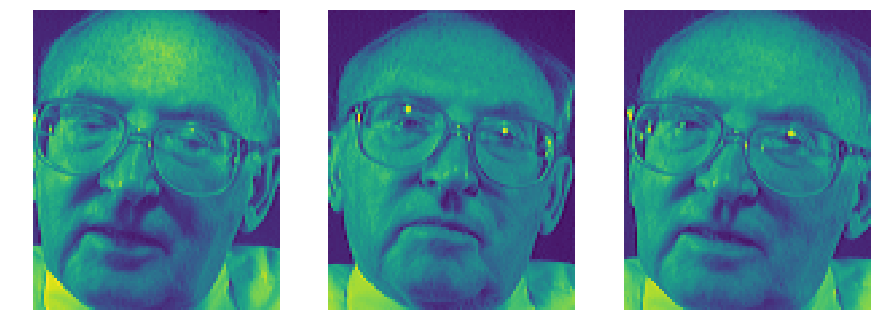

In [6]:
dims = [112,92] # image dims
plots(ims[:,:3].T, dims)

## Standard NMF

For a given matrix $A$, NMF factorizes $A$ into two nonnegative matrices $W$ and $H$. The columns of $W$ can be interpreted as the basis vectors or features of $A$, and the columns of $H$ contain the coefficients for the linear combinations of the columns of $W$ that return the original matrix $A$. Because the factorized matrices are limited to nonnegative values, it is not guaranteed that an exact solution exists. Therefore, we write the the NMF of $A$ as:

$$ A\approx WH^T $$

As for the dimensions of $W$ and $H$, they can be specified. For example, if we wanted to factorize an m-by-n matrix $A$ into its *k* features, the result would be an m-by-k matrix $W$ and a n-by-k matrix $H$. Of course, from a matrix multiplication point of view, this makes sense. However, we can make sense of this intuitively as well.

$$ A\approx W_{m\times k}H_{n\times k}^T $$

If we wanted to extract $k$ features from $A$, we need to have a matrix to describe each of the $k$ features ($W$) and a matrix that specifies how much of each feature is represented in each instance of the data in $A$ ($H$). The m-dimension, then, is simply the dimension of the column vectors in $W$, and $n$ is the number of samples contained in $A$.

We will first use the standard NMF method. We can try NMF with a rank of 10.

In [7]:
rank = 10
max_iter = 12
nmf = nimfa.Nmf(ims, rank = rank, max_iter=max_iter)
nmf_fit = nmf()

Let's take a look at $W$ and $H$:

In [8]:
W = nmf_fit.fit.basis()
H = nmf_fit.fit.coef()

W.shape, H.shape

((10304, 10), (10, 400))

The columns of W contain the basis vectors or feature faces of the dataset. By reshaping each column vector into a 92x112 array, we can visualize it as an image.

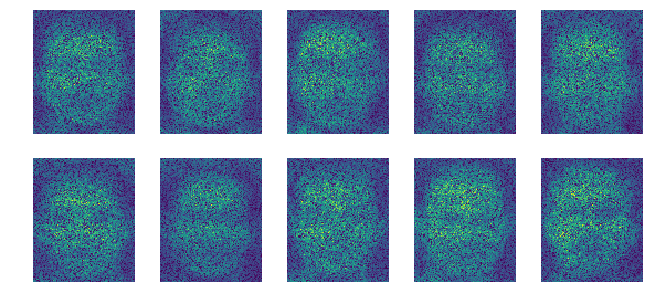

In [9]:
plots(W.T, dims, figsize=(11,5), rows=2)

The columns of $H$ contain the coefficients for the linear combinations of the columns of $W$ needed to recreate each of the 400 images.

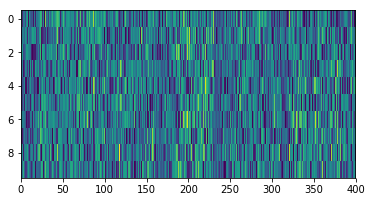

In [10]:
plt.imshow(H, aspect=20);

We can try to reconstruct some of the images using $W$ and $H$, but we can see that the reconstructed images are not very similar to their original counterparts. Additionally, they are quite similar to each other.

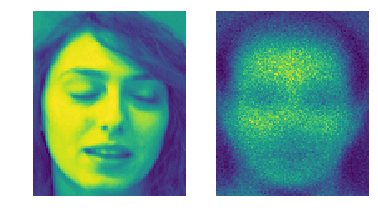

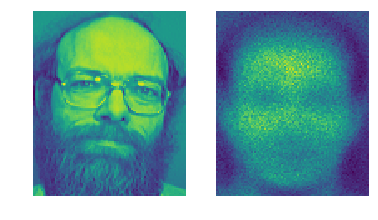

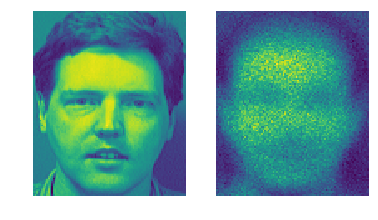

In [11]:
n = [200, 250, 300]
for i in n:
    comp_images(ims, W, H, i, (6, 9))

## Sparse NMF by Alternating Nonnegative Least Squares (ANLS)

We can repeat what we did previously with the SNMF algorithm. This algorithm enforces sparseness on the basis matrix, which, as we will see soon, allows us to obtain a better reconstruction of the original images. The [SNMF by ANLS algorithm](https://www.cc.gatech.edu/~hpark/papers/GT-CSE-08-01.pdf) is used in this case.

Instead of using a rank of 10 as we did before, here we will trying running the method with a rank of 40.

Note: Depending on the rank, the following cell takes a while to run.

In [12]:
rank = 20
max_iter = 12
snmf = nimfa.Snmf(ims, rank = rank, max_iter=max_iter, rcond='None')
snmf_fit = snmf()

The W and H matrices have changed to reflect the new rank size specified.

In [13]:
W_snmf = snmf_fit.fit.basis()
H_snmf = snmf_fit.fit.coef()

W_snmf.shape, H_snmf.shape

((10304, 20), (20, 400))

However, we can see that the columns of $W$ (facial features) are very different. Whereas with the NMF we had grainy and similar features, here each feature highlights a different part of the face (forehead, cheekbones, chin, etc.).

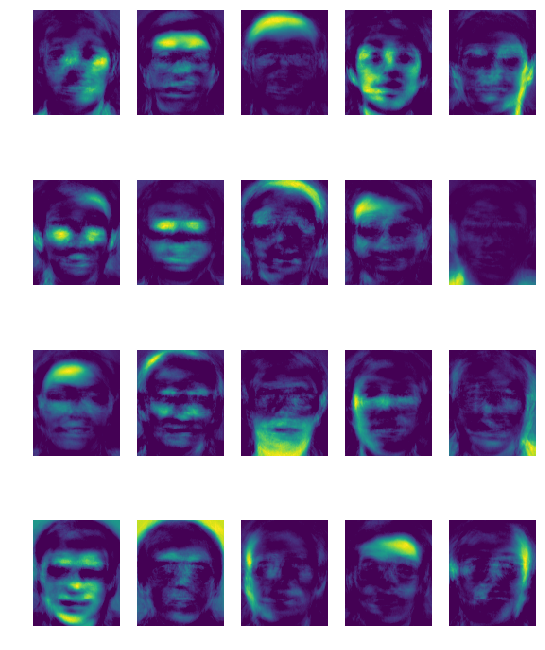

In [14]:
plots(W_snmf.T, dims, figsize=(9,12), rows=4)

Next, if we take a look at the coefficient matrix $H$, it does not seem like much is going on.

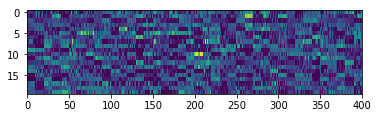

In [15]:
plt.imshow(H_snmf, aspect=5);

However, if we take a closer look at columns 0-9, 10-19, 20-29, 30-39, and 40-49, which correponds to the 10 images of the first five individuals in the dataset, we start to see a pattern emerge.

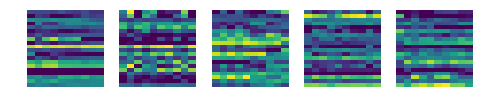

In [16]:
n = 5
fig, axs = plt.subplots(1, n, figsize=(8, 3))
Hrows,_ = H_snmf.shape
Hcols = 10

for i in range(n):
    axs[i].imshow(H_snmf[:,i * Hcols:(i + 1) * Hcols].reshape(Hrows, Hcols), aspect=0.5)
    axs[i].axis('off');

These sub-matrices of $H$ appear to have horizontal striations, which is to say that each of the ten images for each individual have similar linear combinations of the basis matrix $W$. In other words, the ten different pictures for an individual are composed of a similar set of features. Intuitively this makes sense, as, even though the ten pictures of a person may be taken under varying conditions, his/her face is composed of similar features.

If we compare the original images and the reconstructed images, we can see that SNMF performs better than the standard NMF algorithm.

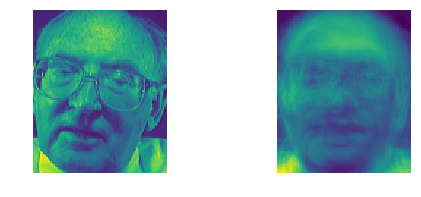

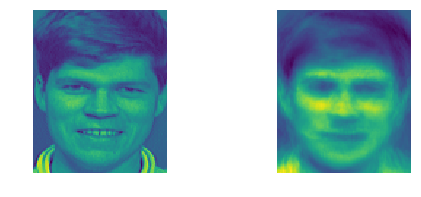

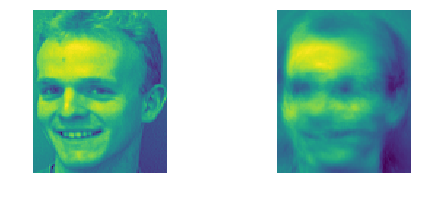

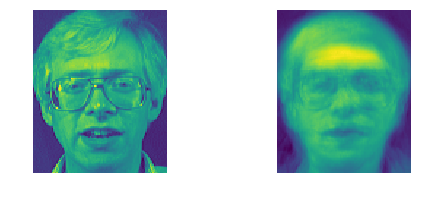

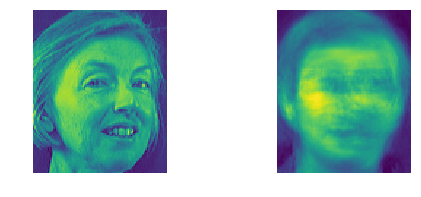

In [17]:
n = 5
for i in range(n):
    comp_images(ims, W_snmf, H_snmf, i * 10)

### Construct your own face

Now that we have these facial features at our disposal, we can have a bit of fun recreating new faces.

In [18]:
from ipywidgets import interact, interactive, fixed

In [19]:
def makeface(W, dims, h1, h2, h3, h4, h5, h6, n):
    plt.imshow(np.reshape(W[:,:6] @ np.array([h1, h2, h3, h4, h5, h6]).T, dims))
    plt.axis('off')

def updateface(W, H, dims, n):
    plt.imshow((W @ H[:,n]).reshape(dims))
    plt.axis('off')

Here are the features that you can use to create a new face (kind of).

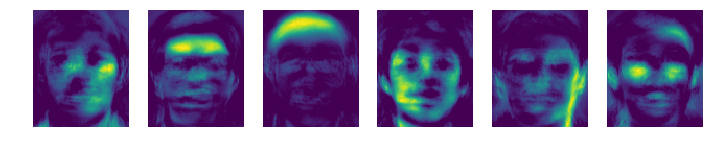

In [20]:
plots(W_snmf[:,:6].T, dims, figsize=(12, 5), rows=1)

In [21]:
interactive(makeface, W=fixed(W_snmf), dims=fixed(dims), h1=(0.,10.), h2=(0.,10.), h3=(0.,10.), 
            h4=(0.,10.), h5=(0.,10.), h6=(0.,10.), n=(0,399,1))

interactive(children=(FloatSlider(value=5.0, description='h1', max=10.0), FloatSlider(value=5.0, description='…

### Consensus Matrix

A great way to visualize the clustering of the data is by plotting a heat map of the consensus matrix, which is the mean connectivity matrix across multiple factorizations. The connectivity matrix is a symmetric matrix that shows shared memberships between items on the rows and columns.

In [22]:
import seaborn as sns

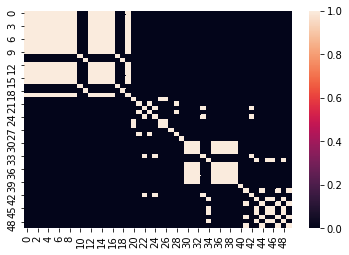

In [23]:
# snmf_fit.fit.consensus().shape
n = 50
sns.heatmap(snmf_fit.fit.consensus()[:n,:n]);

The first 50 rows and columns of the consensus matrix is diagonally dominant and sparse. Additionally, each "block" of ones is roughly 10x10 in dimensions. This can be interpreted as saying that images 0 to 9 are similar to each other and so on for images 10 to 19, 20 to 29, 30 to 39, and 40 to 49.

To show that SNMF was superior to NMF and finding clusters in the dataset, here is the consensus matrix from NMF:

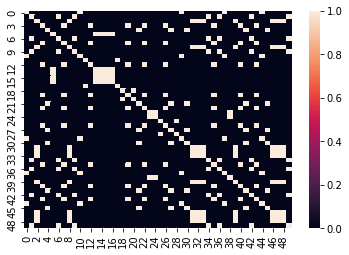

In [24]:
sns.heatmap(nmf_fit.fit.consensus()[:n,:n]);

### My implementation of SNMF by ANLS

Here, I implement the SNMF by ANLS algorithm from scratch with the help of [Autograd from PyTorch](https://pytorch.org/docs/stable/autograd.html). I also compare differences in running the algorithm on a CPU vs. GPUs using AWS.

In [26]:
import torch
from torch.autograd import Variable
import torch.cuda as tc

The algorithm for [SNMF by ANLS](https://www.cc.gatech.edu/~hpark/papers/GT-CSE-08-01.pdf) is as follows:

![snmf_alg](img/SNMF_algorithm.png)

The coefficients $\eta$ and $\beta$ were set as the largest element of the input matrix $A$ and 0.5, respectively.

In [112]:
def report(A, W, H):
    print((A - W.mm(H.t())).norm(2).item())

def penalty(A):
    return torch.pow((A < 0).type(torch.FloatTensor) * torch.clamp(A, max=0), 2)

def loss_H(A, W, H, beta, k, n):
    W_ = torch.cat((W, np.sqrt(beta) * torch.ones(1, k)), 0)
    A_ = torch.cat((A, torch.zeros(1, n)), 0)
    p = penalty(H).mean()

    return (W_.mm(H.t()) - A_).norm(2).pow(2) + 1e6 * p

def loss_W(A, W, H, eta, k, m):
    H_ = torch.cat((H, np.sqrt(eta) * torch.eye(k)), 0)
    A_ = torch.cat((A.t(), torch.zeros(k, m)), 0)
    p = penalty(W).mean()

    return (H_.mm(W.t()) - A_).norm(2).pow(2) + 1e6 * p

def my_snmf(A, k, beta, eta, lr=1e-3, rtol=1e-5, atol=1e-5, max_iter=1000):
    # create matrix A
    m, n = A.shape
    A = Variable(torch.FloatTensor(A), requires_grad=False)

    # initialize parameters to optimize
    W = Variable(torch.rand(m,k),requires_grad=True)
    H = Variable(torch.rand(n,k),requires_grad=True)

    # construct optimizers
    opt_H = torch.optim.Adam([H], lr=1e-3, betas=(0.9, 0.999))
    opt_W = torch.optim.Adam([W], lr=1e-3, betas=(0.9, 0.999))

    opt_H.zero_grad()
    opt_W.zero_grad()
    
    # solve nonnegativity constrained least square problems
    for i in range(max_iter):
        # optimize H, set W constant
        opt_H.zero_grad()
        lH = loss_H(A, W, H, beta, k, n)
        lH.backward()
        opt_H.step()
        H.grad.zero_()

        # optimize W, set H constant
        opt_W.zero_grad()
        lW = loss_W(A, W, H, eta, k, m)
        lW.backward()
        opt_W.step()
        W.grad.zero_()

        # periodically report iteration results
        if i % 1000 == 999:
            report(A, W.data, H.data)

    return W, H

Let's first try with a random matrix.

In [125]:
n = 5
# A = 10 * np.random.rand(n, n)
A = np.random.randint(10,size=(n,n))

rank = 5
max_iter = 100

In [126]:
beta = 0.5
eta = A.max()
W, H = my_snmf(A, rank, beta, eta, lr=1e-3, rtol=1e-5, atol=1e-5, 
               max_iter=10000)

myW = W.detach().numpy()
myH = H.detach().numpy()

11.11750316619873
8.51157283782959
6.946616172790527
6.183650970458984
5.723578929901123
5.423614025115967
5.5705108642578125
5.786276340484619
6.1005072593688965
6.898204803466797


In [127]:
np.allclose(A,myW @ myH.T)

False

#### Comparison to Nimfa implementation

In [128]:
def sparsity(M):
    return 1 - np.count_nonzero(M) / M.size

In [129]:
snmf = nimfa.Snmf(A, rank=rank, max_iter=max_iter, rcond=None)
snmf_fit = snmf()

W_snmf, H_snmf = snmf_fit.fit.basis(), snmf_fit.fit.coef()

In [134]:
A

array([[3, 3, 2, 7, 0],
       [5, 0, 7, 3, 4],
       [7, 5, 7, 5, 3],
       [7, 2, 3, 0, 7],
       [3, 2, 9, 9, 5]])

In [135]:
W_snmf, H_snmf, W_snmf @ H_snmf

(matrix([[0.06405, 0.     , 0.06053, 0.161  , 0.02481],
         [0.     , 0.06134, 0.10025, 0.06983, 0.15614],
         [0.10985, 0.04235, 0.14195, 0.11587, 0.14979],
         [0.04487, 0.12987, 0.14541, 0.00046, 0.07164],
         [0.04066, 0.07786, 0.05574, 0.2078 , 0.18451]]),
 matrix([[ 0.     , 42.66191,  0.     ,  0.     ,  0.     ],
         [ 0.     ,  0.     ,  0.     ,  0.     , 49.12011],
         [45.74937,  0.     ,  0.     ,  0.     ,  0.     ],
         [ 0.57516,  0.90559,  5.79209, 41.61382,  0.     ],
         [ 1.25556,  0.     , 40.36129,  0.     ,  5.6739 ]]),
 matrix([[2.89284, 2.87839, 1.93376, 6.69996, 0.14075],
         [4.82251, 0.06324, 6.70639, 2.90602, 3.89885],
         [6.74868, 4.79143, 6.71702, 4.82186, 2.93016],
         [6.74255, 1.9148 , 2.89433, 0.01922, 6.78584],
         [2.90131, 1.9228 , 8.65082, 8.64718, 4.8716 ]]))

In [137]:
myW, myH, myW @ myH.T

(array([[ 0.17515,  0.86285,  0.21441,  0.00245,  0.00001],
        [-0.00004,  0.52468,  0.90661,  0.00055,  0.00001],
        [ 0.32565,  0.82479,  1.00535,  0.00092,  0.0001 ],
        [ 0.10832, -0.00004,  1.1839 ,  0.00007,  0.00014],
        [ 0.00114,  1.33361,  0.79029,  0.00024,  0.00045]], dtype=float32),
 array([[-0.00004, -0.00002,  5.19215, -0.00006, -0.00006],
        [ 1.13507,  1.42364,  0.86577, -0.00005,  0.00001],
        [-0.00008,  3.33711,  3.25146, -0.00008, -0.00008],
        [-0.00007,  5.96552, -0.00004, -0.00007, -0.00007],
        [-0.00006, -0.00005,  4.28745,  0.00154,  0.00002]], dtype=float32),
 array([[ 1.11322,  1.61283,  3.57657,  5.14736,  0.91922],
        [ 4.70723,  1.53182,  4.6987 ,  3.12992,  3.88701],
        [ 5.21989,  2.41424,  6.02123,  4.92021,  4.31033],
        [ 6.14698,  1.14789,  3.84926, -0.0003 ,  5.0759 ],
        [ 4.10329,  2.58409,  7.02002,  7.95566,  3.38828]], dtype=float32))

In [120]:
np.allclose(myW,W_snmf), np.allclose(myH,H_snmf)

(False, False)

Comparing the Frobenius norms of the two factorizations, we see that Nimfa's SNMF performed slightly better than mine.

In [121]:
np.linalg.norm(A - myW @ myH.T), np.linalg.norm(A - W_snmf @ H_snmf) 

(4.822225384333142, 0.7807302180606178)

## Truncated SVD

Now that we've seen how NMF is used for facial recognition, let's see how SVD does it. In this case, instead of a full SVD, we use truncated SVD to reduce the dimensionality of the data to a specified number.

In [55]:
from sklearn.utils.extmath import randomized_svd

In [106]:
n_components = 20
u, s, vt = randomized_svd(ims, n_components=n_components)

u.shape, s.shape, vt.shape

((10304, 20), (20,), (20, 400))

Unlike NMF, SVD returns matrices $U$ and $V$ that have orthonormal rows and columns, respectively. By definition, then, these matrices multiplied by their transposes should return the identity matrix.

In [107]:
np.allclose(np.eye(u.shape[0]), u @ u.T), np.allclose(np.eye(vt.shape[0]), vt @ vt.T)

(False, True)

Similar to what we did with the feature matrix $W$ in NMF, we can reshape matrix $U$ to visualize the basis vectors.

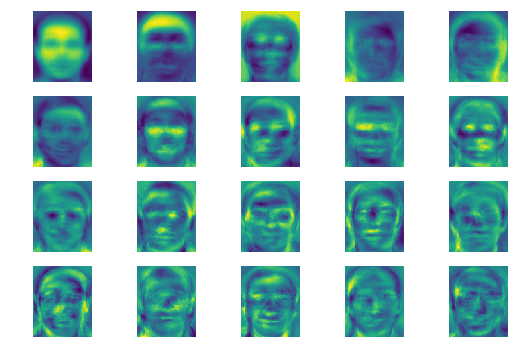

In [108]:
plots(u.T, dims, figsize=(9,6), rows=4)

The singular values contained in s represent the relative importance of each of the features shown above.

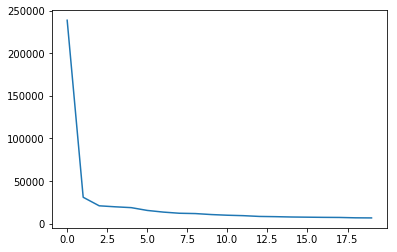

In [109]:
plt.plot(s);

Just as we looked at the $H$ for NMF, we can take a look at $V$ for SVD to visualize the presence of each feature in each image.

As a reminder, the 400 in the horizontal axis represents the 400 images in the dataset and the 20 in the vertical axis represents the 20 components that we decomposed the matrix into.

Unlike NMF and SNMF, the coefficient matrix for SVD shows that every single image has a lot of the first feature contained in it. This is further shown by the plot of the singular values (above).

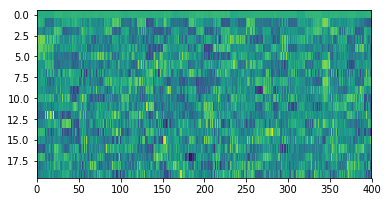

In [112]:
plt.imshow(vt, aspect=10);

## References